In [1]:
### Stacked autoencoder class
#
## 사용법
# ae = autoencoder() # 객체 생성
# ae.make(x)         # x 데이터 셋에 맞춰 그래프 만들기
# ae.train(x)        # 학습하기
#
## ae.train(x) 리턴값
# encoding, outputs = ae.train(x)
# encoding: 중요한 feature 로 인코딩된 정보들
# outputs: encoding 정보를 바탕으로 디코딩한 출력들
#
## 그 외 메소드들
# set_layer(hidden1, hidden2) : 히든 레이어 사이즈 설정
# set_train(n_epochs, learning_rate, batch_size, l2_reg=0.0001) : 학습 파라미터 설정
#
## 멤버 변수
# shape0 : 전체 데이터 수
# n_inputs : 데이터 feature 수 (df.shape[1])
# n_hidden1 : 인코더 레이어 크기
# n_hidden2 : 인코딩 유닛 크기
# n_hidden3 : 디코더 레이어 크기 (=n_hidden1)
# n_outputs : 디코딩된 출력 크기 (=n_inputs)
# n_epochs : 총 에폭 수
# learning_rate : 학습률
# batch_size : 미니배치 크기
# l2_reg : l2 규제율 (https://kolikim.tistory.com/50) (https://stackoverflow.com/questions/37107223/how-to-add-regularizations-in-tensorflow)

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from functools import partial
from datetime import datetime
import os

C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\f

In [3]:
class autoencoder():
    # 생성자. 사용될 변수 미리 선언
    def __init__(self, n_hidden1=40, n_hidden2=20):
        self.shape0 = None               # 전체 데이터 수
        
        self.n_inputs = None             # input size
        self.n_hidden1 = n_hidden1       # encoder layer size
        self.n_hidden2 = n_hidden2       # coding units size (like PCA)
        self.n_hidden3 = self.n_hidden1  # decoder layer size
        self.n_outputs = self.n_inputs   # restruction
        
        self.n_epochs = 5
        self.learning_rate = 0.01
        self.batch_size = 150
        self.l2_reg = 0.0001
    
    # 레이어 사이즈 설정
    def set_layer(self, n_hidden1, n_hidden2):
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = self.n_hidden1
        self.n_outputs = self.n_inputs

    # 학습 파라미터 설정
    def set_train(self, n_epochs, learning_rate, batch_size, l2_reg=0.0001):
        if not self.shape0:
            print('메소드 make_autoencoder 를 먼저 실행해주세요')
            return
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_batches = self.shape0 // batch_size
        self.l2_reg = l2_reg
        
    def make(self, df):
        self.shape0 = df.shape[0]
        self.n_inputs = df.shape[1]
        self.n_outputs = self.n_inputs # autoencoder: input_size==output_size
        if self.batch_size > df.shape[0]:
            print(f'batch_size가 {self.shape0}로 변경됨')
            self.batch_size = self.shape0
        self.n_batches = self.shape0 // self.batch_size
        
        he_init = tf.keras.initializers.he_normal() # He 초기화
        l2_regularizer = tf.contrib.layers.l2_regularizer(scale=self.l2_reg) # L2 규제
        
        # partial 을 이용한 tf.layers.dense 의 새 버전 만들기
        # partial 첫번째 인자는 새 버전 만들 원본.
        # 나머지 인자는 원본 함수가 갖는 인자를 재정의 하는데 쓰인다.
        dense_layer = partial(tf.layers.dense,
                              activation=tf.nn.relu,
                              kernel_initializer=he_init,
                              kernel_regularizer=l2_regularizer)
        
        # Stacked Automater 구성
        self.inputs = tf.placeholder(tf.float32, shape=[None, self.n_inputs])

        self.hidden1 = dense_layer(self.inputs, self.n_hidden1)
        self.hidden2 = dense_layer(self.hidden1, self.n_hidden2)
        self.hidden3 = dense_layer(self.hidden2, self.n_hidden3)
        self.coding_units = self.hidden2

        self.outputs = dense_layer(self.hidden3, self.n_outputs, activation=None)

        # loss
        self.reconstruction_loss = tf.reduce_mean(tf.square(self.outputs - self.inputs)) # mse
        self.reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        self.loss = tf.add_n([self.reconstruction_loss] + self.reg_losses)

        # optimizer
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        # saver
        self.saver = tf.train.Saver()

    def shuffle_batch(self, features, seed):
#         np.random.seed(seed) # 시드 설정시 학습이 안됨. 주석처리.
        shuffled_index = np.random.permutation(self.n_inputs)
        for batch_idx in np.array_split(shuffled_index, self.n_batches):
            batch_x = features[batch_idx]
        yield batch_x
        
    def train(self, train_x, tag=''):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for epoch in range(self.n_epochs):
                for _ in range(self.n_batches):
                    batch_x = next(self.shuffle_batch(train_x, epoch+datetime.now().hour)) # seed: 현재 시간+epoch
                    _, _loss = sess.run([self.train_op, self.reconstruction_loss], feed_dict={self.inputs:batch_x})
                print(f'epoch: {epoch+1}/{self.n_epochs}, Train MSE: {_loss:.10f}')
            coding_units = sess.run(self.coding_units, feed_dict={self.inputs:train_x})
            outputs = sess.run(self.outputs, feed_dict={self.inputs:train_x})
            # 학습 끝나면 레이어 중앙의 인코딩 유닛과 디코딩된 아웃풋 리턴
            return coding_units, outputs 
        
            # train/ 디렉토리에 모델 저장합니다.
            self.saver.save(sess, f'trained/trained_autoencoder_{tag}')

#     # 저장된 모델 불러오기 및 인코딩유닛 리턴하기 --미구현--
#     # 'Attempting to use uninitialized value' error..
#     def get(self, tag=''):
#         with tf.Session() as sess:
#             if os.path.exists(f'trained/trained_autoencoder_{tag}'):
#                 saver = tf.train.import_meta_graph(f'trained/trained_autoencoder_{tag}.meta')
#                 saver.restore(sess, f'trained/trained_autoencoder_{tag}')
#             coding_units_val = sess.run(self.coding_units, feed_dict={self.inputs:df_small[:2]})
#         return coding_units




### MNIST 데이터로 오토인코더 잘 작동하는지 확인하기

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True) # MNIST_data 는 .gitignore 에 추가할것.

images = mnist.train.images

W0827 03:05:12.509181 18836 deprecation.py:323] From <ipython-input-4-60a5a6863027>:3: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0827 03:05:12.511176 18836 deprecation.py:323] From C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0827 03:05:12.512172 18836 deprecation.py:323] From C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting MNIST_data/train-images-idx3-ubyte.gz


W0827 03:05:12.767491 18836 deprecation.py:323] From C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0827 03:05:12.769484 18836 deprecation.py:323] From C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W0827 03:05:12.819351 18836 deprecation.py:323] From C:\Users\MAIN\Anaconda3\envs\kaggle\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and

Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
ae = autoencoder()     # 오토인코더 객체 생성
ae.set_layer(400, 200) # 히든레이어 사이즈 히든1:400 히든2:200 설정
ae.make(images)        # 그래프 만들기
encoding, outputs = ae.train(images) # 학습하기 -> 인코딩유닛, 아웃풋 리턴

W0827 03:05:13.105587 18836 deprecation.py:323] From <ipython-input-3-b1acc88e4f32>:58: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


epoch: 1/5, Train MSE: 0.0598920807
epoch: 2/5, Train MSE: 0.0495522134
epoch: 3/5, Train MSE: 0.0516839474
epoch: 4/5, Train MSE: 0.0363627411
epoch: 5/5, Train MSE: 0.0670374259


(55000, 784)
(55000, 200)


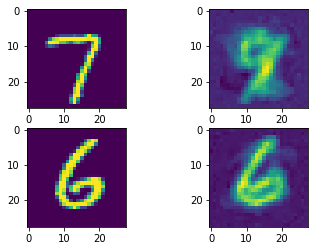

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2,2)

axes[0][0].imshow(images[100].reshape(28,28))
axes[0][1].imshow(outputs[100].reshape(28,28))
axes[1][0].imshow(images[1000].reshape(28,28))
axes[1][1].imshow(outputs[1000].reshape(28,28))

print(images.shape)   # (55000, 784)
print(encoding.shape) # (55000, 200) 784 features -> 200 features